## LIBRERÍAS Y CARGA DE DATOS

In [1]:
from google.colab import files
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import random
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import math
import itertools
import torchvision
from torch.optim import lr_scheduler
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms





In [2]:
# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d shreyag1103/brain-mri-scans-for-brain-tumor-classification

# Descomprimir el archivo descargado
!unzip -q brain-mri-scans-for-brain-tumor-classification.zip -d /content/multi_brain_tumor_dataset

Saving kaggle.json to kaggle.json
Archivo subido: kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification
License(s): unknown
 45% 11.0M/24.4M [00:00<00:00, 46.1MB/s]
100% 24.4M/24.4M [00:00<00:00, 76.2MB/s]


In [216]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Redimensionar las imágenes a un tamaño uniforme
            images.append(img)
            labels.append(label)
    return images, labels

# Rutas a los datasets
base_dir = '/content/multi_brain_tumor_dataset/data'
glioma = '/content/multi_brain_tumor_dataset/data/glioma'
meningioma = '/content/multi_brain_tumor_dataset/data/meningioma'
notumor = '/content/multi_brain_tumor_dataset/data/notumor'
pituitary = '/content/multi_brain_tumor_dataset/data/pituitary'

## EXPLORACIÓN Y VISUALIZACIÓN DE DATOS

In [217]:
pd.DataFrame(os.listdir(base_dir),columns=['Files_Name'])

,Files_Name
0,pituitary
1,glioma
2,meningioma
3,notumor


In [218]:
files = [i for i in glob.glob(base_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/content/multi_brain_tumor_dataset/data/mening...,meningioma
1,/content/multi_brain_tumor_dataset/data/mening...,meningioma
2,/content/multi_brain_tumor_dataset/data/mening...,meningioma
3,/content/multi_brain_tumor_dataset/data/mening...,meningioma
4,/content/multi_brain_tumor_dataset/data/pituit...,pituitary
...,...,...
1306,/content/multi_brain_tumor_dataset/data/notumo...,notumor
1307,/content/multi_brain_tumor_dataset/data/mening...,meningioma
1308,/content/multi_brain_tumor_dataset/data/mening...,meningioma
1309,/content/multi_brain_tumor_dataset/data/mening...,meningioma


<ipython-input-219-74d39fa4c446>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe["Label"], palette=palette)


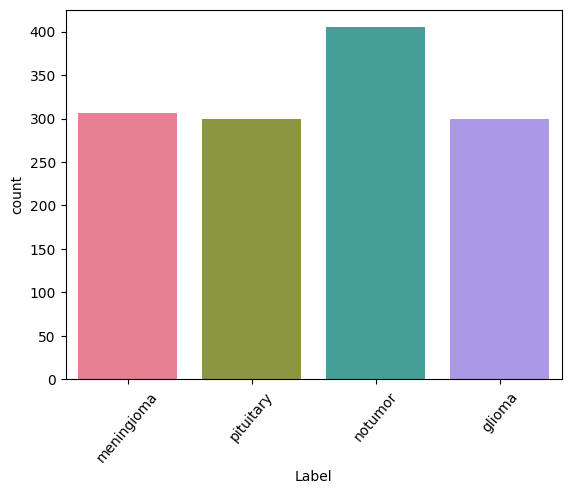

In [219]:
palette = sns.color_palette("husl", len(dataframe["Label"].unique()))

# Crea el gráfico de barras con la paleta de colores
sns.countplot(x=dataframe["Label"], palette=palette)

# Rota las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=50)

# Muestra el gráfico
plt.show()

In [220]:
# Cargar imágenes y etiquetas de cada categoría
glioma_images, glioma_labels = load_images_from_folder(glioma, 0)  # 1 para Tumor
meningioma_images, meningioma_labels = load_images_from_folder(meningioma, 1)  # 0 para Healthy
notumor_images, notumor_labels = load_images_from_folder(notumor, 2)  # 1 para Tumor
pituitary_images, pituitary_labels = load_images_from_folder(pituitary, 3)  # 0 para Healthy

## NORMALIZACIÓN, DIVISIÓN DEL Y PREPROCESAMIENTO DEL CONJUNTO DE DATOS

In [221]:
# Combinar datasets
images = np.array(glioma_images + meningioma_images + notumor_images +  pituitary_images)
labels = np.array(glioma_labels + meningioma_labels + notumor_labels + pituitary_labels)

# Normalizar los valores de los píxeles
images = images / 255.0



In [222]:
# Dividir el dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)



## **MODELO 1**

In [224]:
model = Sequential([
    Input(shape=(64,64,1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [225]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [226]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
25/25 [==============================] - 3s 25ms/step - loss: 1.2288 - accuracy: 0.4071 - val_loss: 1.0919 - val_accuracy: 0.5458
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9615 - accuracy: 0.6234 - val_loss: 0.8643 - val_accuracy: 0.6565
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.7536 - accuracy: 0.7188 - val_loss: 0.7701 - val_accuracy: 0.6870
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6544 - accuracy: 0.7341 - val_loss: 0.8190 - val_accuracy: 0.6985
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6039 - accuracy: 0.7710 - val_loss: 0.7121 - val_accuracy: 0.6679
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5764 - accuracy: 0.7824 - val_loss: 0.6825 - val_accuracy: 0.7252
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5102 - accuracy: 0.8130 - val_loss: 0.6880 - val_accuracy: 0.7252
Epoch 8/50
25/25 [=

In [227]:
hist_=pd.DataFrame(history.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,1.228767,0.407125,1.091917,0.545802
1,0.961453,0.623410,0.864270,0.656489
2,0.753641,0.718830,0.770077,0.687023
3,0.654450,0.734097,0.818977,0.698473
4,0.603944,0.770992,0.712112,0.667939
5,0.576381,0.782443,0.682501,0.725191
6,0.510206,0.812977,0.688030,0.725191
7,0.461083,0.819338,0.633333,0.744275
8,0.417970,0.837150,0.649053,0.759542
9,0.447204,0.812977,0.610638,0.751908


In [228]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

9/9 [==============================] - 0s 15ms/step - loss: 0.4644 - accuracy: 0.7985
Loss en los datos de prueba: 0.464435875415802
Precisión en los datos de prueba: 0.7984790802001953


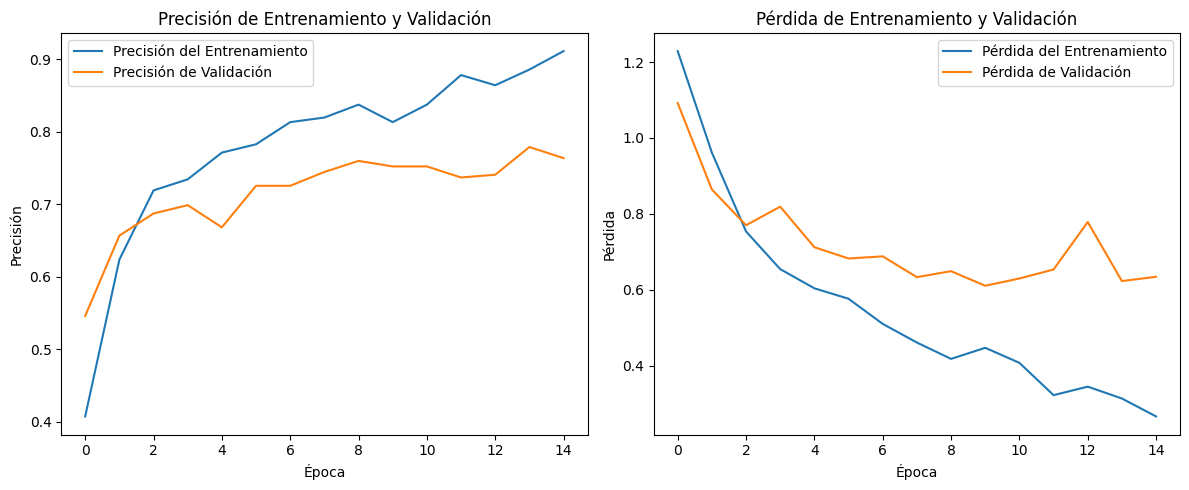

In [229]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [230]:
# Realizar predicciones con salida detallada
y_pred_prob = model.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas usando argmax
y_pred = np.argmax(y_pred_prob, axis=1)

# Asegurar que y_test y y_pred tengan la misma longitud
if len(y_test) == len(y_pred):
    results = pd.DataFrame({
        'Etiqueta Actual': y_test.flatten(),
        'Etiqueta Predicha': y_pred.flatten()
    })

    # Convertir las etiquetas a "Healthy" y "Tumor"
    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})

    print(results)
else:
    print("Error: y_test y y_pred no tienen la misma longitud.")


9/9 [==============================] - 0s 2ms/step
    Etiqueta Actual Etiqueta Predicha
0        Meningioma          No tumor
1        Meningioma          No tumor
2            Glioma        Meningioma
3         Pituitary         Pituitary
4            Glioma            Glioma
..              ...               ...
258       Pituitary         Pituitary
259       Pituitary         Pituitary
260       Pituitary         Pituitary
261          Glioma            Glioma
262       Pituitary         Pituitary

[263 rows x 2 columns]


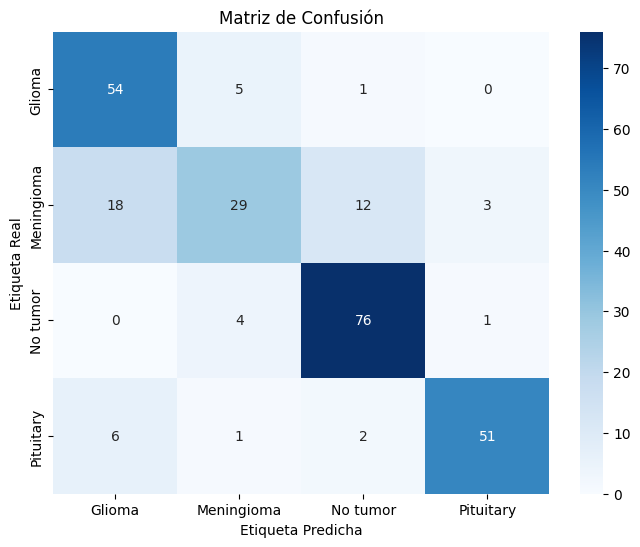

In [231]:
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'], yticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()


In [232]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
print(report)

              precision    recall  f1-score   support

      Glioma       0.69      0.90      0.78        60
  Meningioma       0.74      0.47      0.57        62
    No tumor       0.84      0.94      0.88        81
   Pituitary       0.93      0.85      0.89        60

    accuracy                           0.80       263
   macro avg       0.80      0.79      0.78       263
weighted avg       0.80      0.80      0.79       263



In [233]:
y_prob = model.predict(X_val)


9/9 [==============================] - 0s 2ms/step


In [234]:
# Convertir y_val a one-hot encoding
y_val_one_hot = label_binarize(y_val, classes=[0, 1, 2, 3])


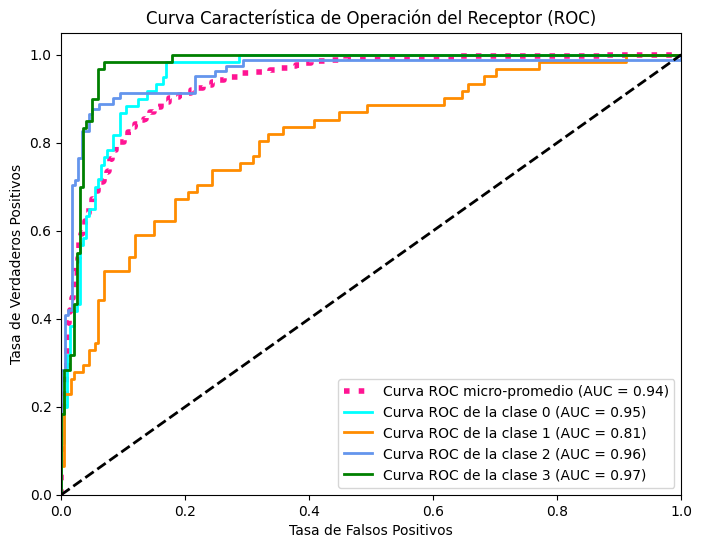

In [235]:
# Calcular la curva ROC y el AUC para cada clase
fpr = dict()  # Tasa de falsos positivos
tpr = dict()  # Tasa de verdaderos positivos
roc_auc = dict()  
n_classes = 4  # Número de clases

# Calcular para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_one_hot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-average ROC y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_one_hot.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot de las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Curva ROC micro-promedio (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Colores para las curvas ROC de cada clase
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()



In [236]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64))  
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1)  
        img = np.expand_dims(img, axis=0) 
        return img
    else:
        return None

def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        return class_names[predicted_class]
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        probability = prediction[0][predicted_class]
        return (class_names[predicted_class], probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)



In [237]:
# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

1/1 [==============================] - 0s 16ms/step


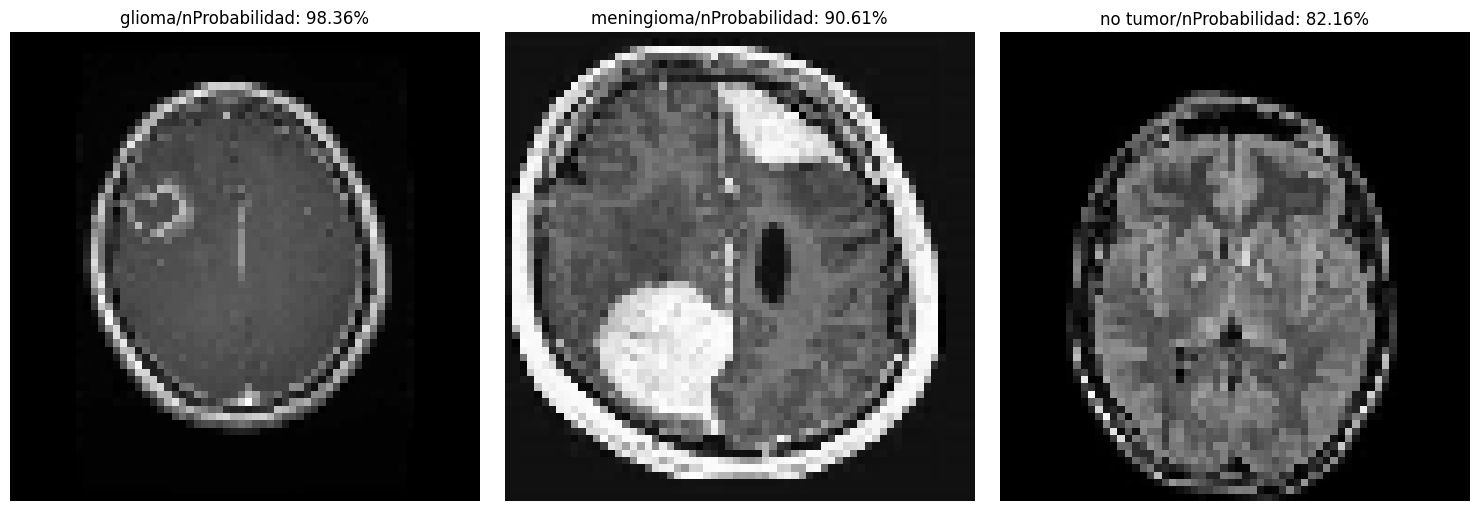

In [238]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [239]:
# Cargar y preprocesar la imagen 
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (64, 64)) 
    img = img / 255.0  
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)  
    return img


# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [240]:
# Listar las capas del Modelo 1
print("Layers of Model 1:")
for layer in model.layers:
    print(layer.name)


Layers of Model 1:
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense


In [241]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'  
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png' 
img_array2 = load_and_preprocess_image(image_path2)
# Lista de imágenes
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

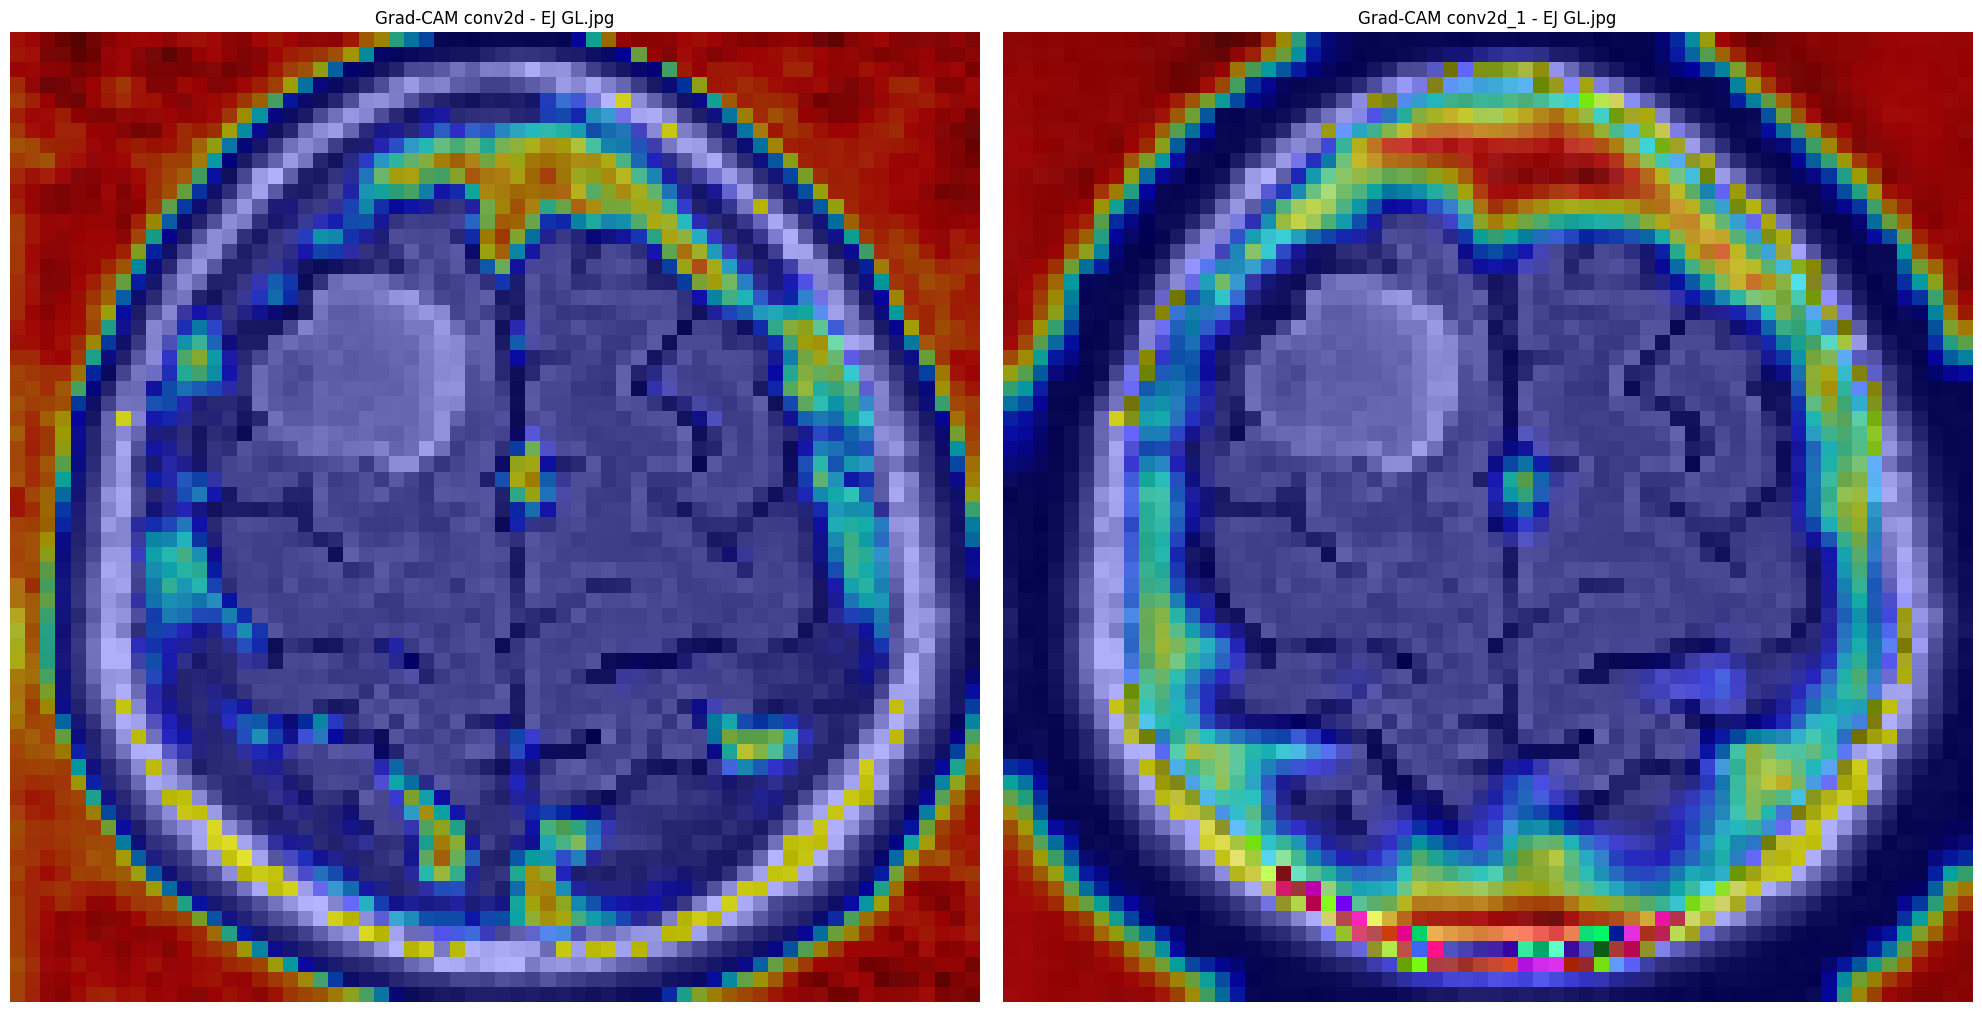

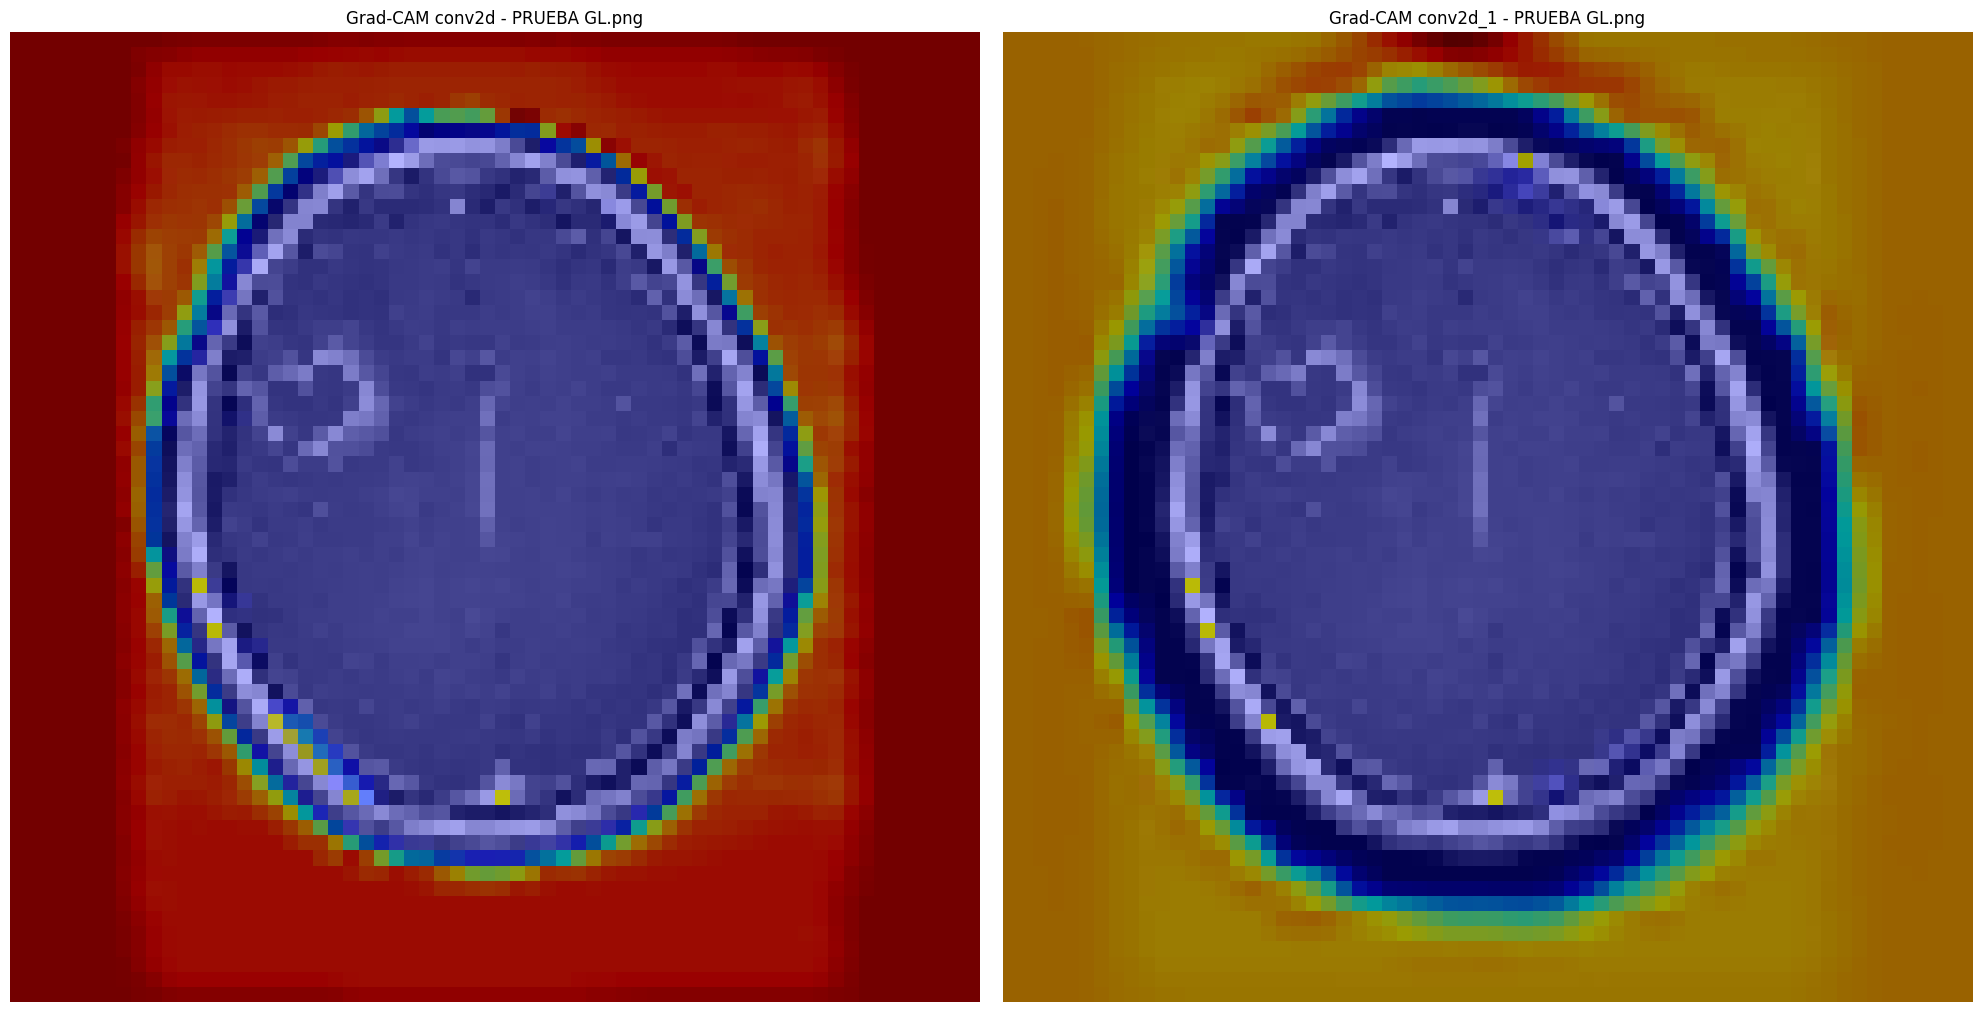

In [243]:
# Generar y visualizar Grad-CAM para cada modelo
layer_names_model1 = ['conv2d', 'conv2d_1']

# Para Modelo 1
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model1):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model1), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## **MODELO 2**

In [244]:
model2 = Sequential([
    Input(shape=(64,64,1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(4, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [245]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history2 = model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
25/25 [==============================] - 2s 25ms/step - loss: 1.2149 - accuracy: 0.4415 - val_loss: 1.0132 - val_accuracy: 0.5802
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.8753 - accuracy: 0.6679 - val_loss: 0.8804 - val_accuracy: 0.5763
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7494 - accuracy: 0.7125 - val_loss: 0.7172 - val_accuracy: 0.7137
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5867 - accuracy: 0.7646 - val_loss: 0.6613 - val_accuracy: 0.7405
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5082 - accuracy: 0.8041 - val_loss: 0.7067 - val_accuracy: 0.6794
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4524 - accuracy: 0.8244 - val_loss: 0.6751 - val_accuracy: 0.7634
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4340 - accuracy: 0.8333 - val_loss: 0.6532 - val_accuracy: 0.7557
Epoch 8/50
25/25 [=

In [246]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model2.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

9/9 [==============================] - 0s 19ms/step - loss: 0.4372 - accuracy: 0.8441
Loss en los datos de prueba: 0.4372377097606659
Precisión en los datos de prueba: 0.8441064357757568


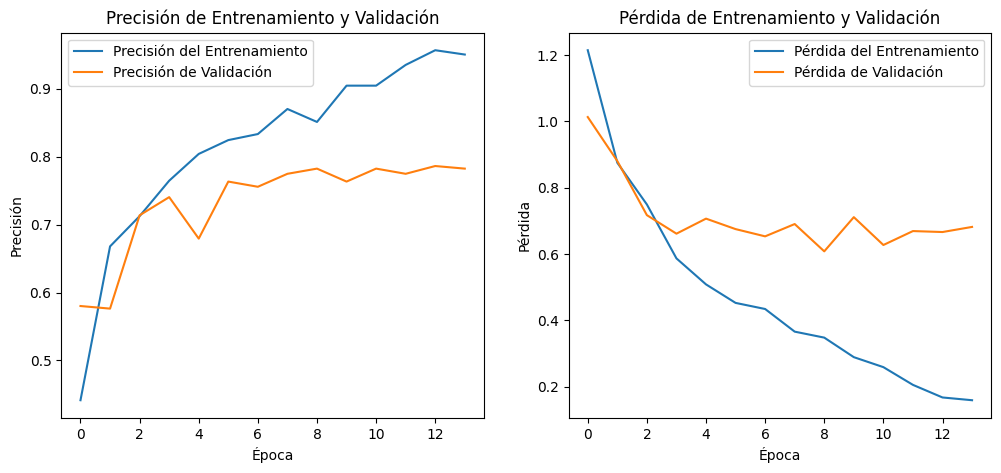

In [247]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()


In [248]:
# Realizar predicciones con salida detallada
y_pred_prob = model2.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas usando argmax
y_pred = np.argmax(y_pred_prob, axis=1)

# Asegurar que y_test y y_pred tengan la misma longitud
if len(y_test) == len(y_pred):
    # Crear un DataFrame para mostrar etiquetas reales y predichas
    results = pd.DataFrame({
        'Etiqueta Actual': y_test.flatten(),
        'Etiqueta Predicha': y_pred.flatten()
    })

    # Convertir las etiquetas a "Healthy" y "Tumor"
    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})


    # Mostrar el DataFrame
    print(results)
else:
    print("Error: y_test y y_pred no tienen la misma longitud.")


9/9 [==============================] - 0s 3ms/step
    Etiqueta Actual Etiqueta Predicha
0        Meningioma          No tumor
1        Meningioma        Meningioma
2            Glioma        Meningioma
3         Pituitary         Pituitary
4            Glioma            Glioma
..              ...               ...
258       Pituitary         Pituitary
259       Pituitary         Pituitary
260       Pituitary         Pituitary
261          Glioma            Glioma
262       Pituitary         Pituitary

[263 rows x 2 columns]


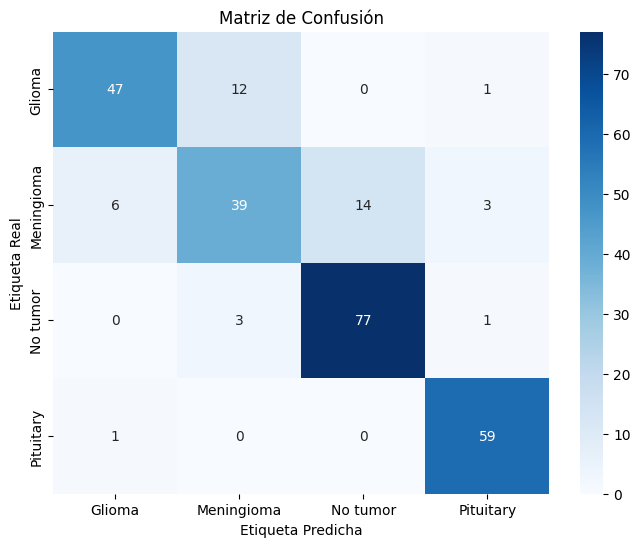

In [249]:
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'], yticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()


In [250]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
print(report)

              precision    recall  f1-score   support

      Glioma       0.87      0.78      0.82        60
  Meningioma       0.72      0.63      0.67        62
    No tumor       0.85      0.95      0.90        81
   Pituitary       0.92      0.98      0.95        60

    accuracy                           0.84       263
   macro avg       0.84      0.84      0.84       263
weighted avg       0.84      0.84      0.84       263



9/9 [==============================] - 0s 2ms/step


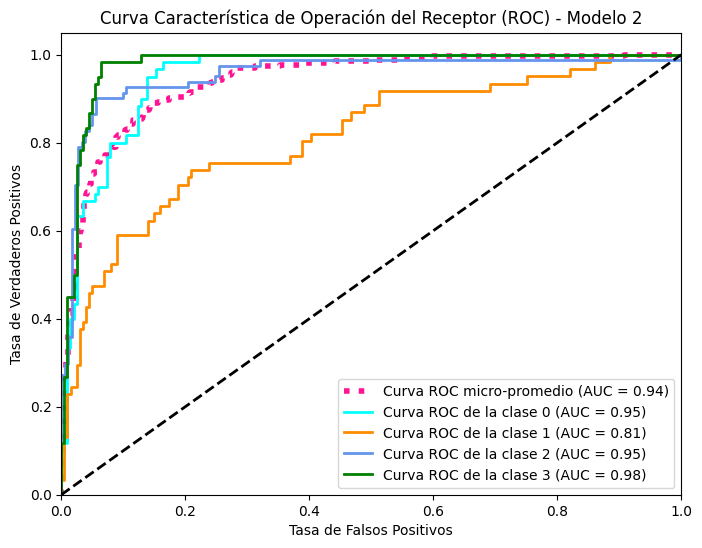

In [251]:
# Obtener predicciones probabilísticas para y_prob_model2
y_prob_model2 = model2.predict(X_val)

# Convertir y_val a one-hot encoding
y_val_one_hot = label_binarize(y_val, classes=[0, 1, 2, 3])

# Calcular la curva ROC y el AUC para cada clase
fpr_model2 = dict()
tpr_model2 = dict()
roc_auc_model2 = dict()
n_classes = 4

for i in range(n_classes):
    fpr_model2[i], tpr_model2[i], _ = roc_curve(y_val_one_hot[:, i], y_prob_model2[:, i])
    roc_auc_model2[i] = auc(fpr_model2[i], tpr_model2[i])

# Calcular el micro-average ROC y AUC
fpr_model2["micro"], tpr_model2["micro"], _ = roc_curve(y_val_one_hot.ravel(), y_prob_model2.ravel())
roc_auc_model2["micro"] = auc(fpr_model2["micro"], tpr_model2["micro"])

# Plot de las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_model2["micro"], tpr_model2["micro"],
         label='Curva ROC micro-promedio (AUC = {0:0.2f})'
               ''.format(roc_auc_model2["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Colores para las curvas ROC de cada clase
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_model2[i], tpr_model2[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc_model2[i]))

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC) - Modelo 2')
plt.legend(loc="lower right")
plt.show()



In [252]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64)) 
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1) 
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

def predict_tumor_model2(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        return class_names[predicted_class]
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model2(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        probability = prediction[0][predicted_class]
        return (class_names[predicted_class], probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 [==============================] - 0s 18ms/step


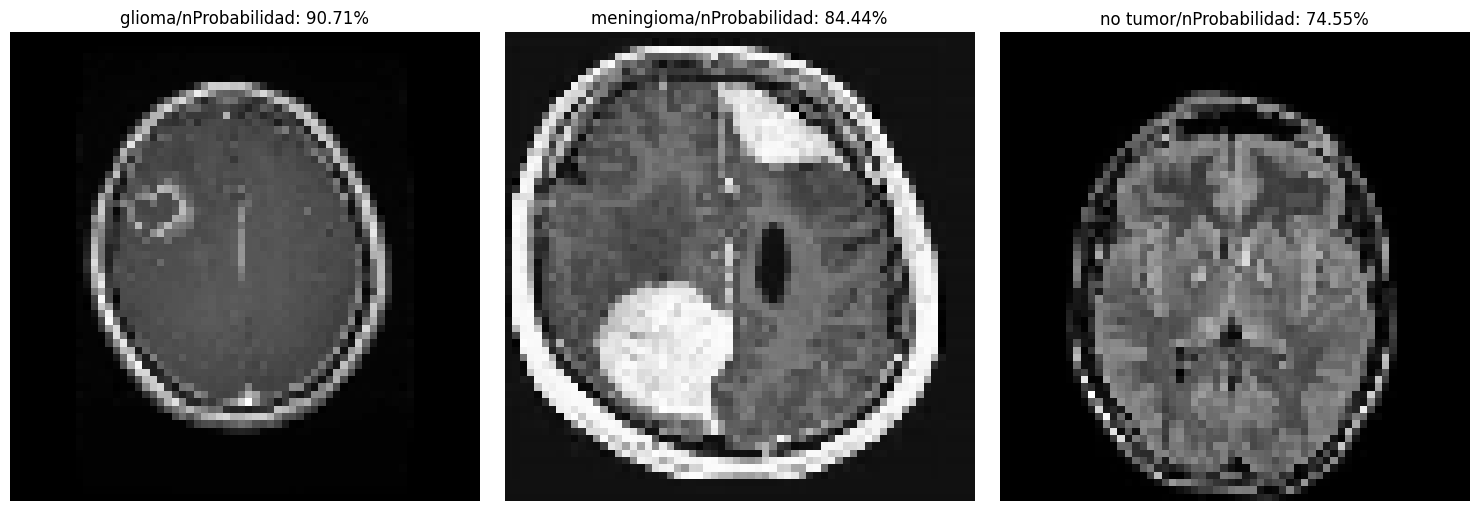

In [253]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model2(image_path, model2)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [254]:
# Cargar y preprocesar la imagen 
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (64, 64))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)  
    return img


# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [255]:
# Listar las capas del Modelo 2
print("Layers of Model 2:")
for layer in model2.layers:
    print(layer.name)


Layers of Model 2:
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten_1
dense_1


In [256]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'  
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png'  
img_array2 = load_and_preprocess_image(image_path2)
# Lista de imágenes
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

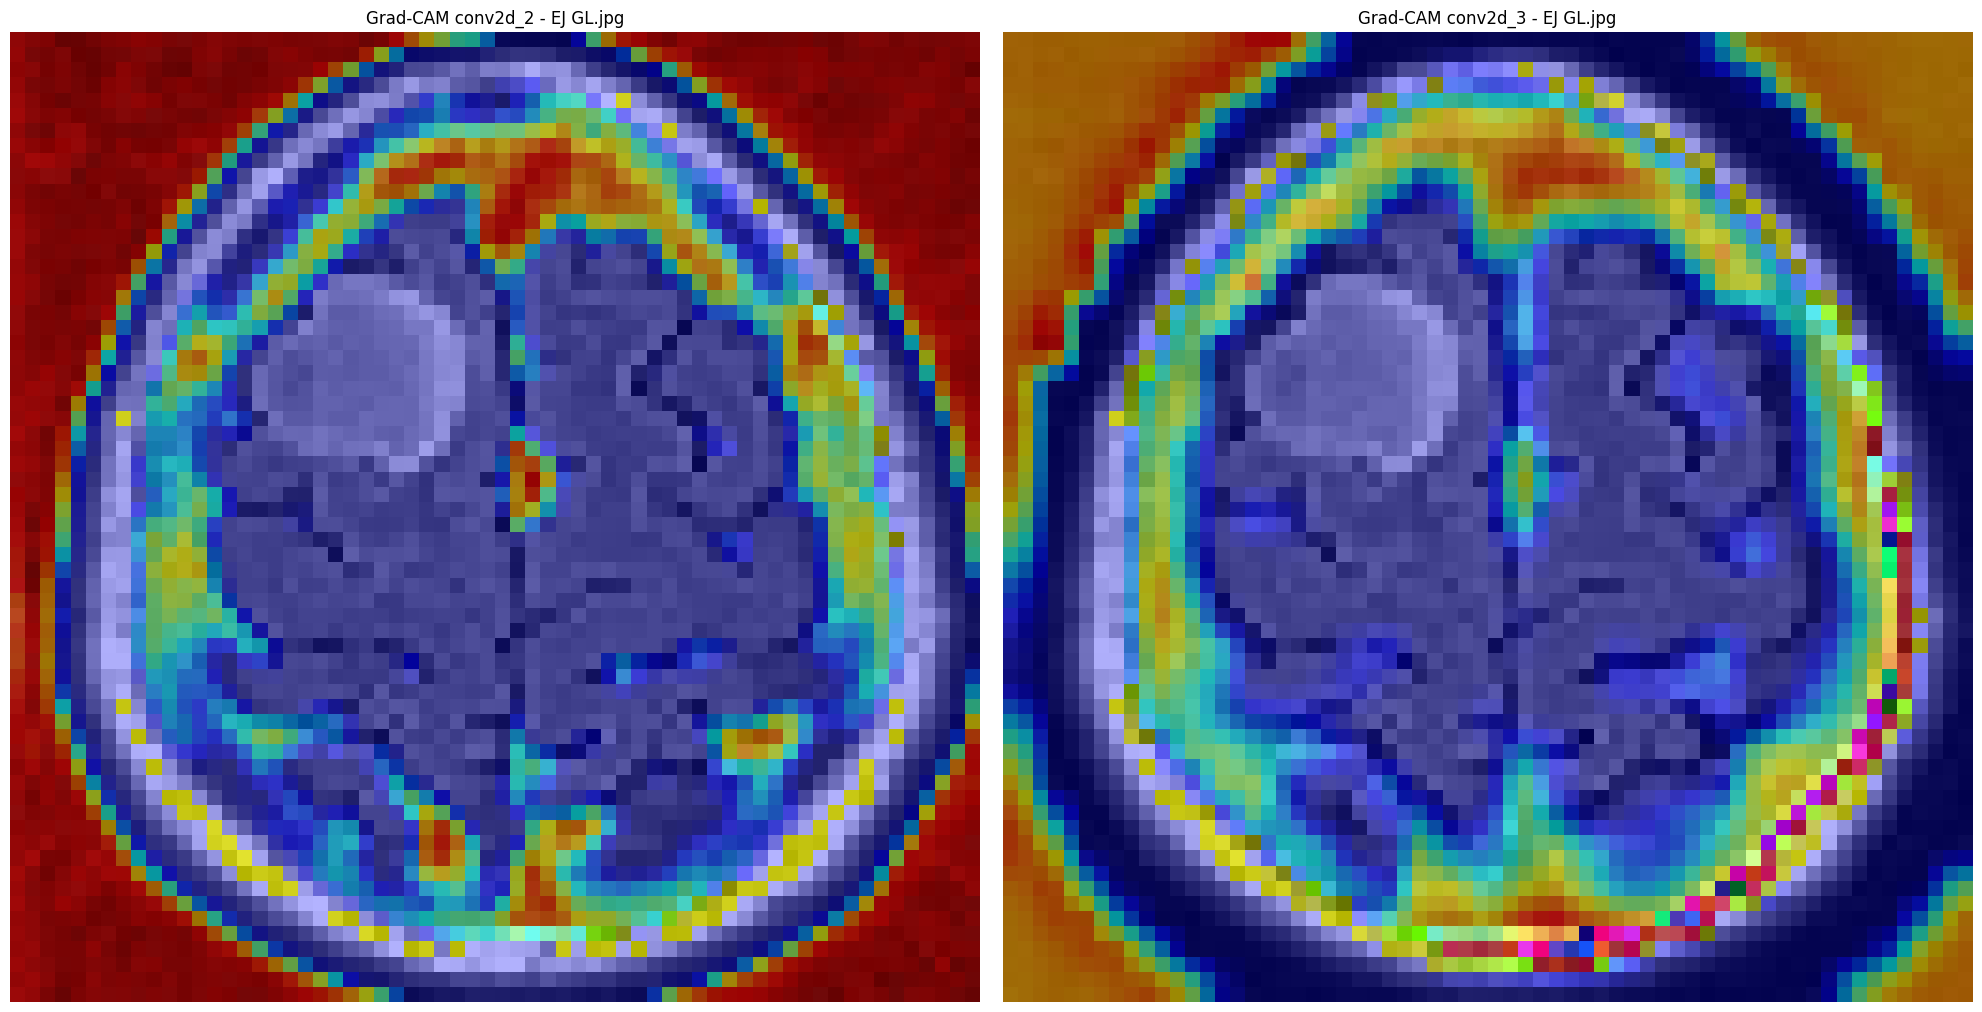

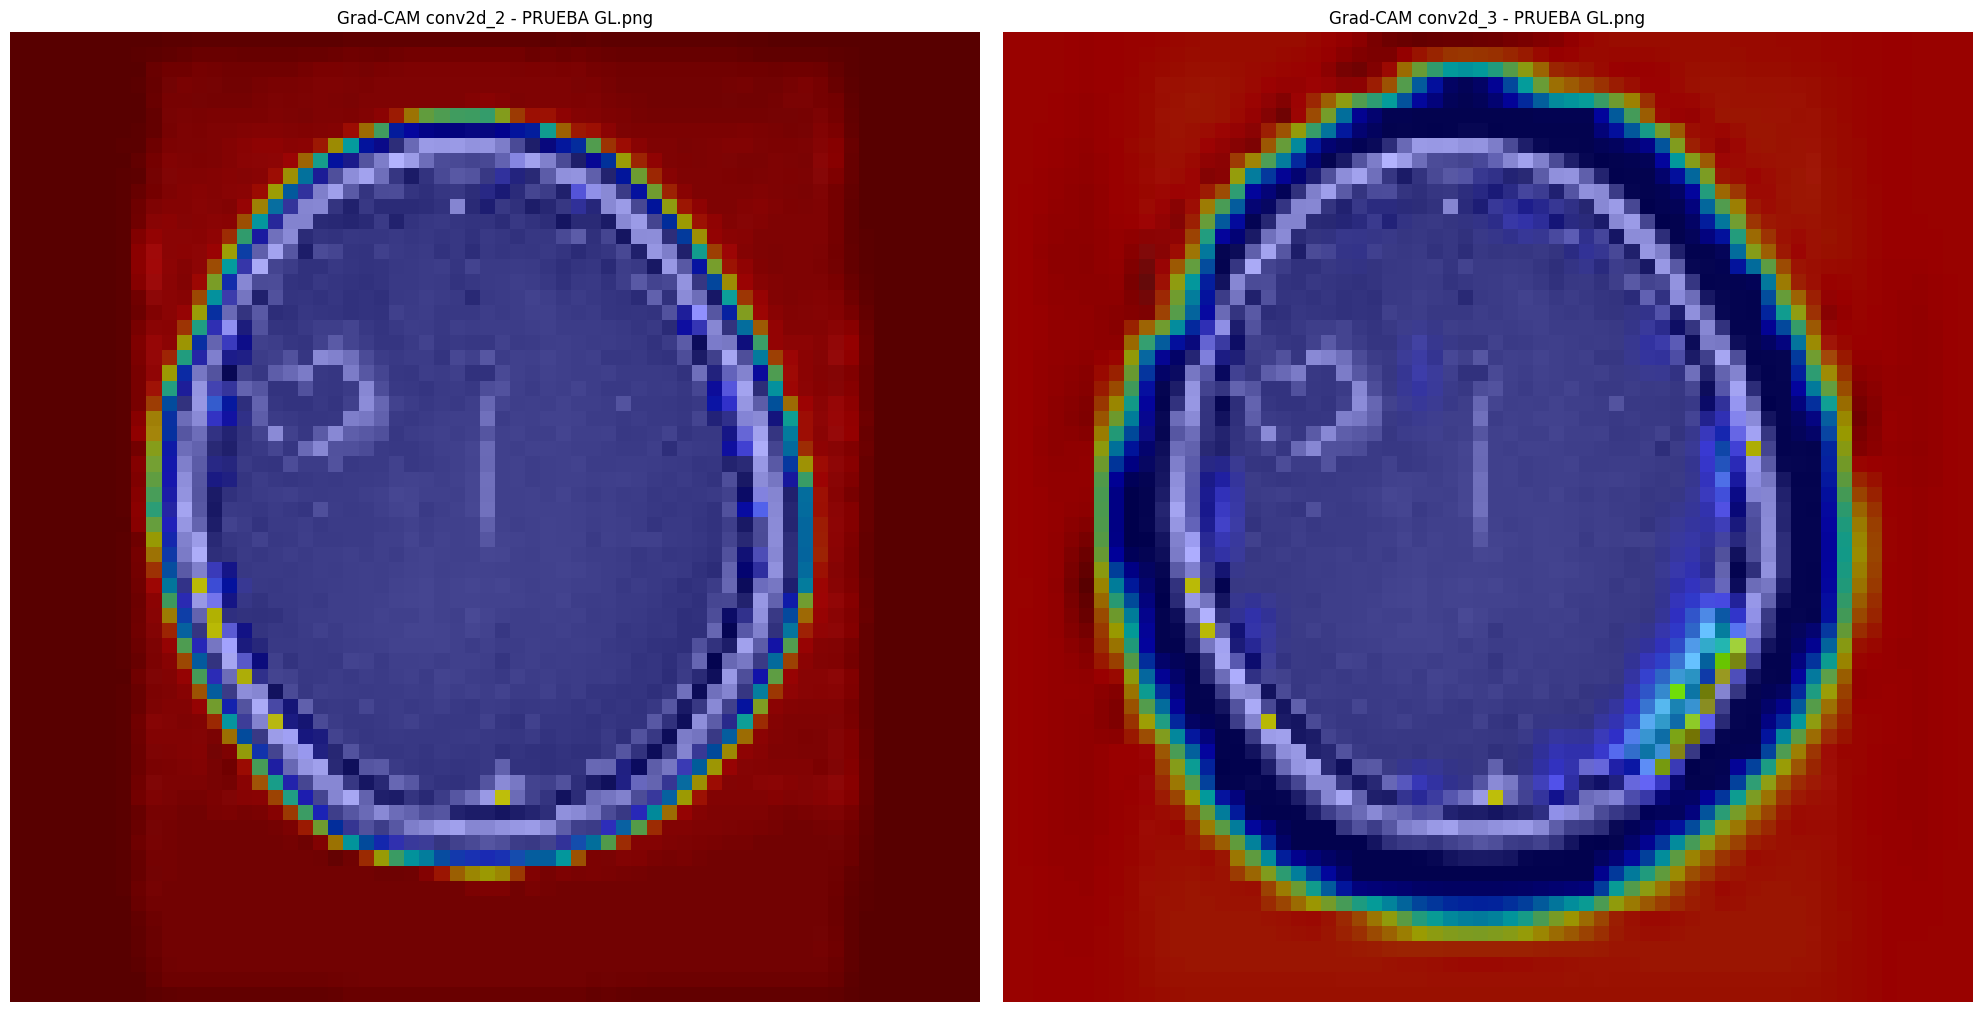

In [258]:
# Generar y visualizar Grad-CAM para cada modelo
layer_names_model2 = ['conv2d_2', 'conv2d_3']

# Para Modelo 2
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model2):
        heatmap = get_gradcam(model2, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model2), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## **MODELO 3**

In [259]:

model3 = Sequential([
    Input(shape=(64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history3 = model3.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
25/25 [==============================] - 4s 31ms/step - loss: 1.3730 - accuracy: 0.3193 - val_loss: 1.3483 - val_accuracy: 0.3092
Epoch 2/50
25/25 [==============================] - 0s 10ms/step - loss: 1.3089 - accuracy: 0.3130 - val_loss: 1.2814 - val_accuracy: 0.4504
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 1.2256 - accuracy: 0.4364 - val_loss: 1.1463 - val_accuracy: 0.6489
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 1.0877 - accuracy: 0.5534 - val_loss: 0.9560 - val_accuracy: 0.6565
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.9978 - accuracy: 0.5954 - val_loss: 0.8803 - val_accuracy: 0.6756
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.9141 - accuracy: 0.6221 - val_loss: 0.8161 - val_accuracy: 0.6870
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.8780 - accuracy: 0.6501 - val_loss: 0.7453 - val_accuracy: 0.7137
Epoch 8/50
25/25

In [260]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model3.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

9/9 [==============================] - 0s 8ms/step - loss: 0.4441 - accuracy: 0.8365
Loss en los datos de prueba: 0.4441125988960266
Precisión en los datos de prueba: 0.8365018963813782


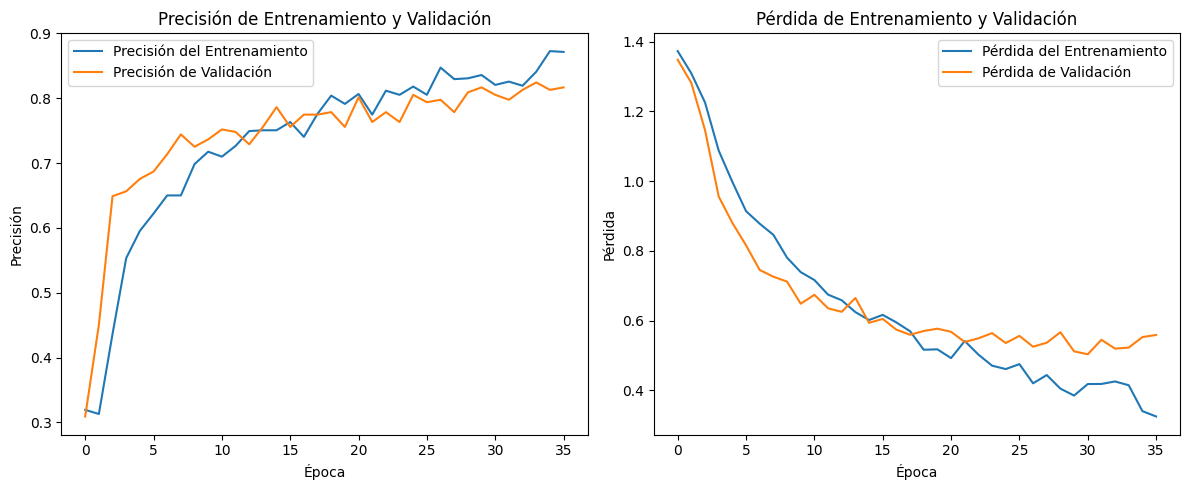

In [261]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history3.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history3.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [262]:
# Realizar predicciones con salida detallada
y_pred_prob = model3.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas usando argmax
y_pred = np.argmax(y_pred_prob, axis=1)

# Asegurar que y_test y y_pred tengan la misma longitud
if len(y_test) == len(y_pred):
    results = pd.DataFrame({
        'Etiqueta Actual': y_test.flatten(),
        'Etiqueta Predicha': y_pred.flatten()
    })

    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Glioma', 1: 'Meningioma', 2: 'No tumor', 3: 'Pituitary'})
    
    print(results)
else:
    print("Error: y_test y y_pred no tienen la misma longitud.")

9/9 [==============================] - 0s 2ms/step
    Etiqueta Actual Etiqueta Predicha
0        Meningioma          No tumor
1        Meningioma        Meningioma
2            Glioma            Glioma
3         Pituitary         Pituitary
4            Glioma            Glioma
..              ...               ...
258       Pituitary         Pituitary
259       Pituitary         Pituitary
260       Pituitary         Pituitary
261          Glioma            Glioma
262       Pituitary         Pituitary

[263 rows x 2 columns]


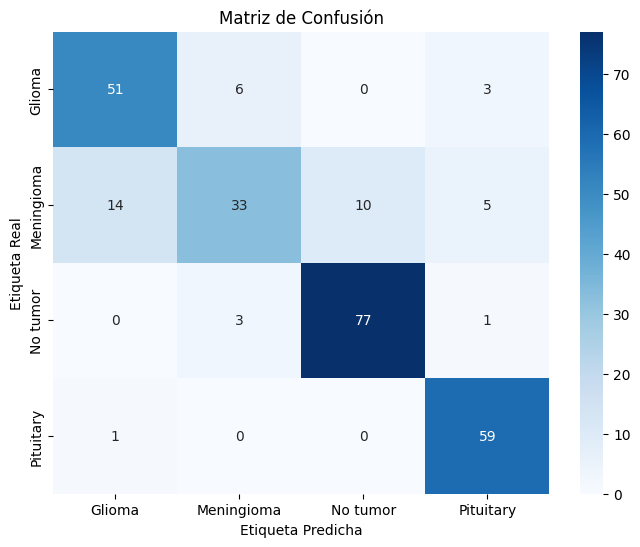

In [263]:
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'], yticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [264]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
print(report)

              precision    recall  f1-score   support

      Glioma       0.77      0.85      0.81        60
  Meningioma       0.79      0.53      0.63        62
    No tumor       0.89      0.95      0.92        81
   Pituitary       0.87      0.98      0.92        60

    accuracy                           0.84       263
   macro avg       0.83      0.83      0.82       263
weighted avg       0.83      0.84      0.83       263



In [265]:
y_prob_model3 = model3.predict(X_val)



9/9 [==============================] - 0s 2ms/step


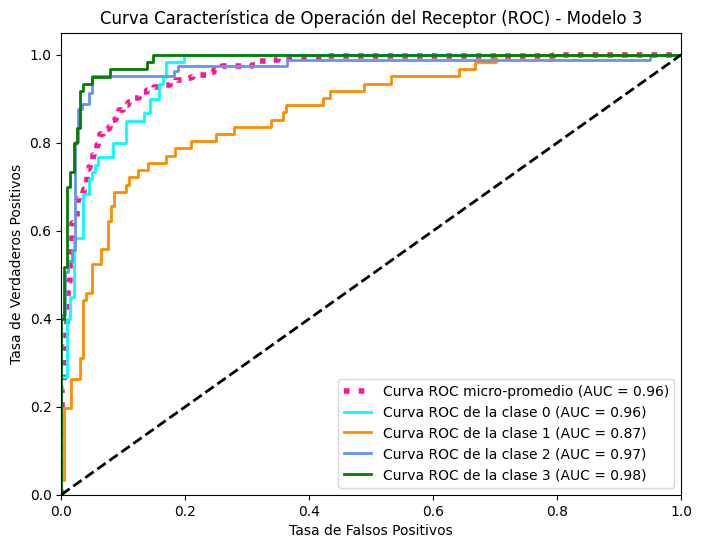

In [266]:

# Convertir y_val a one-hot encoding
y_val_one_hot = label_binarize(y_val, classes=[0, 1, 2, 3])

# Calcular la curva ROC y el AUC para cada clase
fpr_model3 = dict()
tpr_model3 = dict()
roc_auc_model3 = dict()
n_classes = 4

for i in range(n_classes):
    fpr_model3[i], tpr_model3[i], _ = roc_curve(y_val_one_hot[:, i], y_prob_model3[:, i])
    roc_auc_model3[i] = auc(fpr_model3[i], tpr_model3[i])

# Calcular el micro-average ROC y AUC
fpr_model3["micro"], tpr_model3["micro"], _ = roc_curve(y_val_one_hot.ravel(), y_prob_model3.ravel())
roc_auc_model3["micro"] = auc(fpr_model3["micro"], tpr_model3["micro"])

# Plot de las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_model3["micro"], tpr_model3["micro"],
         label='Curva ROC micro-promedio (AUC = {0:0.2f})'
               ''.format(roc_auc_model3["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Colores para las curvas ROC de cada clase
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_model3[i], tpr_model3[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc_model3[i]))

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC) - Modelo 3')
plt.legend(loc="lower right")
plt.show()



In [267]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64)) 
        img = img / 255.0 
        img = np.expand_dims(img, axis=-1) 
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

def predict_tumor_model3(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model3.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        return class_names[predicted_class]
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model3(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model3.predict(img)
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class = np.argmax(prediction)
        probability = prediction[0][predicted_class]
        return (class_names[predicted_class], probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 [==============================] - 0s 16ms/step


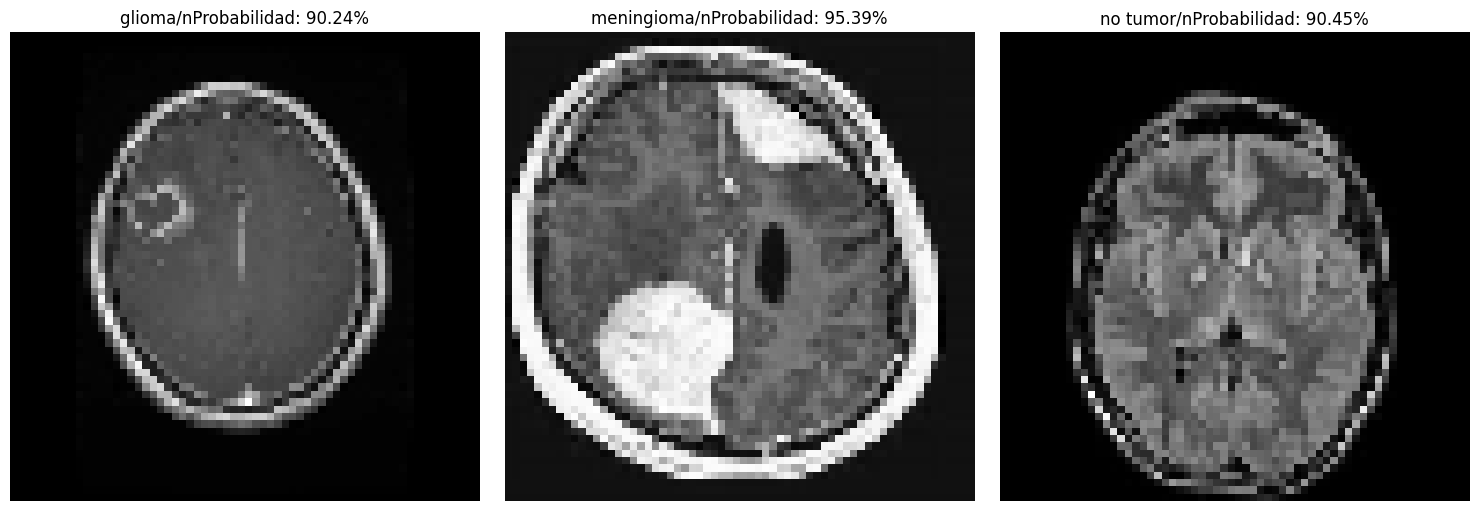

In [268]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model3(image_path, model3)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [269]:
# Cargar y preprocesar la imagen 
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (64, 64))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)  
    return img


# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [270]:
# Listar las capas del Modelo 3
print("Layers of Model 3:")
for layer in model3.layers:
    print(layer.name)


Layers of Model 3:
conv2d_4
max_pooling2d_4
dropout
conv2d_5
max_pooling2d_5
dropout_1
conv2d_6
max_pooling2d_6
dropout_2
flatten_2
dense_2
dropout_3
dense_3


In [271]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'  
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png'  
img_array2 = load_and_preprocess_image(image_path2)
# Lista de imágenes
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

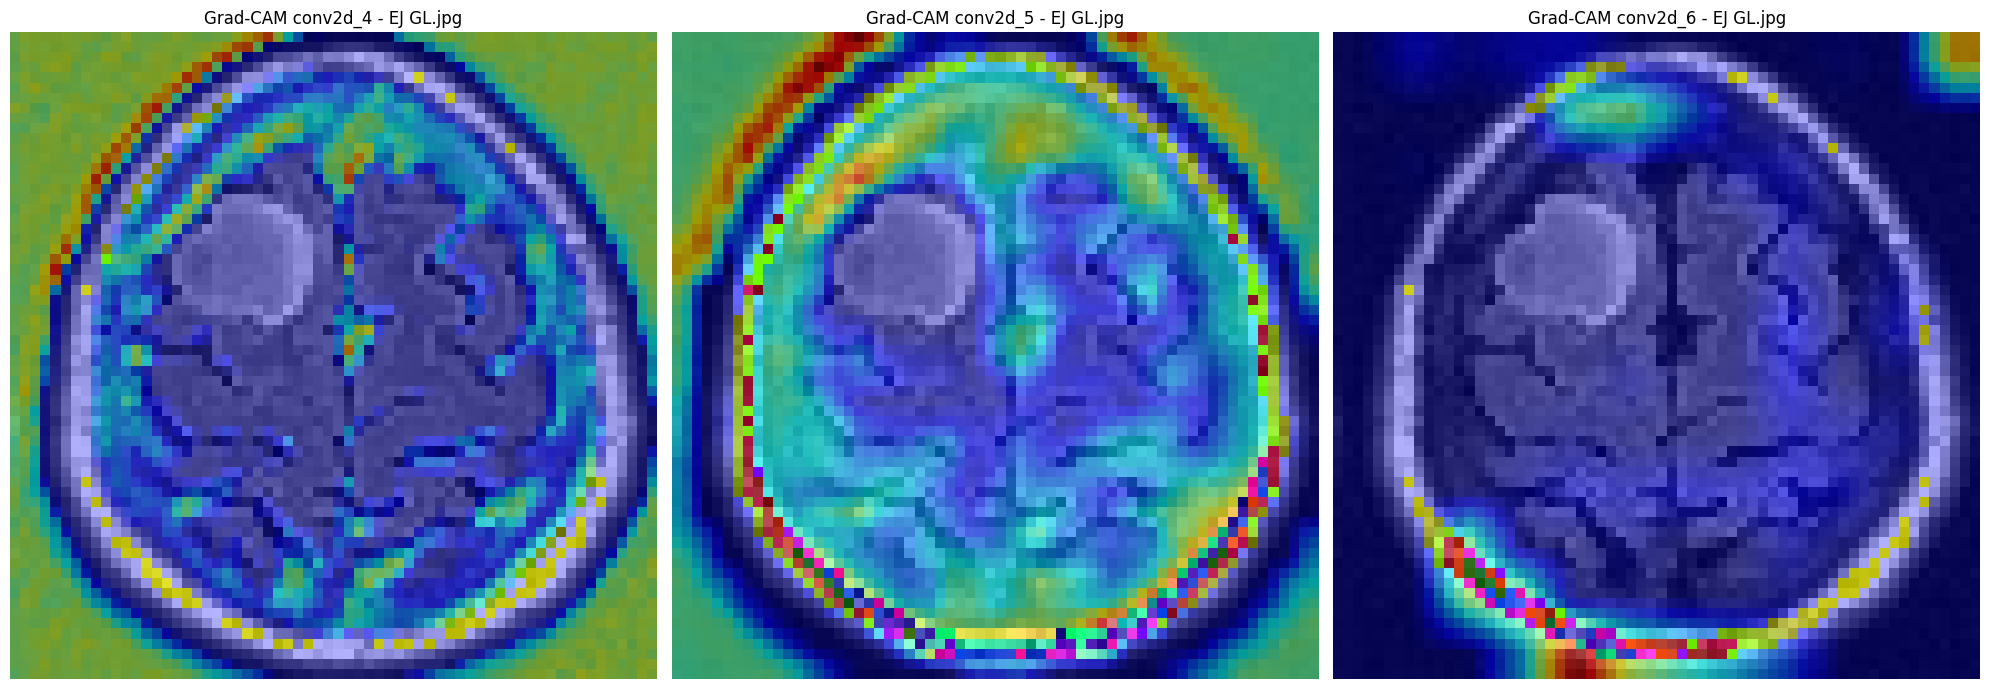

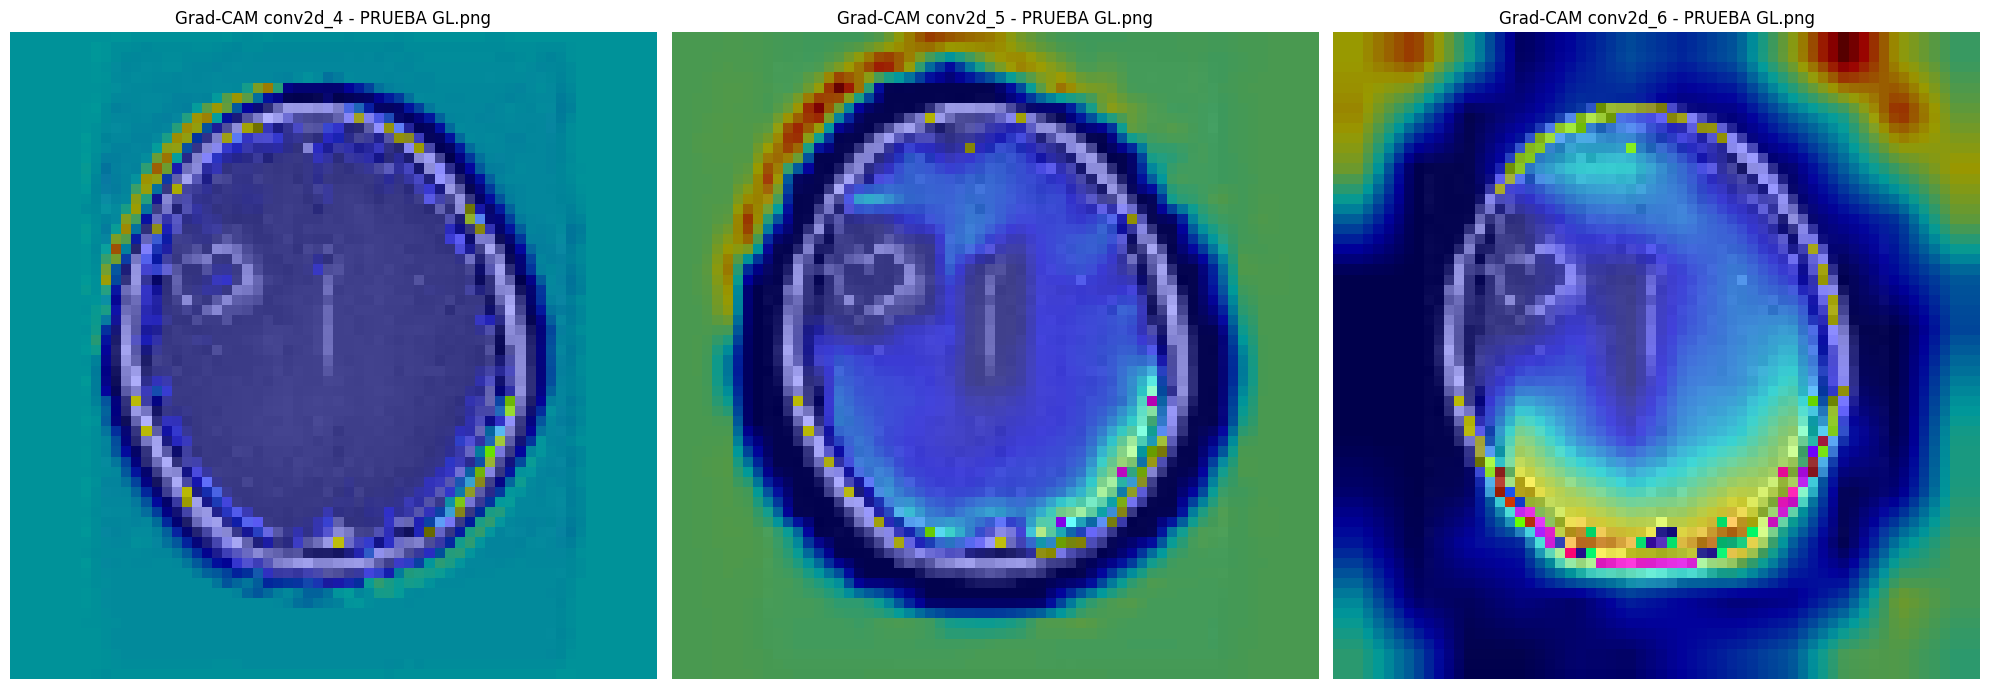

In [273]:
# Generar y visualizar Grad-CAM para cada modelo
layer_names_model3 = ['conv2d_4', 'conv2d_5', 'conv2d_6']

# Para Modelo 3
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model3):
        heatmap = get_gradcam(model3, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model3), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# **COMPARAR MODELOS**

In [274]:
def compare_models(history, history2, history3, model, model2, model3, X_test, y_test):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.plot(history3.history['accuracy'], label='Modelo 3 - Precisión en Entrenamiento')
    plt.plot(history3.history['val_accuracy'], label='Modelo 3 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.plot(history3.history['loss'], label='Modelo 3 - Pérdida en Entrenamiento')
    plt.plot(history3.history['val_loss'], label='Modelo 3 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model.evaluate(X_test, y_test, verbose=0)
    score2 = model2.evaluate(X_test, y_test, verbose=0)
    score3 = model3.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")
    print(f"Modelo 3 - Pérdida: {score3[0]}, Precisión: {score3[1]}")

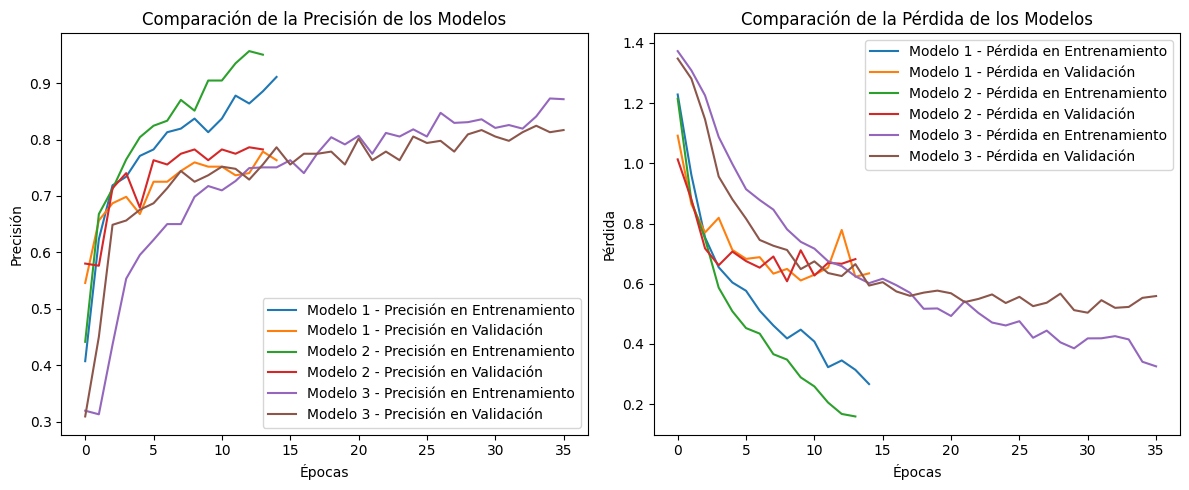

Modelo 1 - Pérdida: 0.464435875415802, Precisión: 0.7984790802001953
Modelo 2 - Pérdida: 0.4372377097606659, Precisión: 0.8441064357757568
Modelo 3 - Pérdida: 0.4441125988960266, Precisión: 0.8365018963813782


In [275]:
compare_models(history, history2, history3, model, model2, model3, X_test, y_test)

# **MODELO PYTORCH**

In [276]:
original_data_dir = '/content/multi_brain_tumor_dataset/data'


folders = os.listdir(original_data_dir)


val_split = 0.2


split_data_dir = '/content/split_multi_data'
os.makedirs(split_data_dir, exist_ok=True)


for folder in folders:
    folder_path = os.path.join(original_data_dir, folder)
    images = os.listdir(folder_path)


    random.shuffle(images)
    split_index = int(len(images) * (1 - val_split))
    train_images = images[:split_index]
    val_images = images[split_index:]

    
    train_dir = os.path.join(split_data_dir, 'train', folder)
    val_dir = os.path.join(split_data_dir, 'val', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

   
    for image in train_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.copy(src, dst)

print("División completa.")

split_data_dir2 = '/content/split_multi_data'


train_count = 0
val_count = 0


for folder in ['train', 'val']:
    for subfolder in os.listdir(os.path.join(split_data_dir2, folder)):
        folder_path = os.path.join(split_data_dir2, folder, subfolder)
        num_images = len(os.listdir(folder_path))
        if folder == 'train':
            train_count += num_images
        elif folder == 'val':
            val_count += num_images

print(f"El número total de imágenes en train es: {train_count}")
print(f"El número total de imágenes en val es: {val_count}")


División completa.
El número total de imágenes en train es: 1260
El número total de imágenes en val es: 475


In [278]:
batch_size = 32
image_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [279]:
image_datasets = {x: datasets.ImageFolder(os.path.join(split_data_dir2, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Categorías: {class_names}")
print(f"Tamaño conjunto de entrenamiento: {dataset_sizes['train']}")
print(f"Tamaño conjunto de validación: {dataset_sizes['val']}")

Categorías: ['glioma', 'meningioma', 'notumor', 'pituitary']
Tamaño conjunto de entrenamiento: 1260
Tamaño conjunto de validación: 475


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [280]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [304]:
model_py = models.resnet18(pretrained=True)


num_ftrs = model_py.fc.in_features
model_py.fc = nn.Linear(num_ftrs, len(class_names)) 

model_py = model_py.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_py.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [305]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = float('inf')  

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Guardar el histórico de entrenamiento y validación
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Hacer una copia profunda del mejor modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss  
                best_model_wts = model.state_dict()

        print()

    print(f'Mejor val prec: {best_acc:.4f} con pérdida: {best_loss:.4f}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Entrenar el modelo y obtener los históricos
model_py, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_py, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25)



Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 1.0451 Acc: 0.5556
val Loss: 0.6065 Acc: 0.8042

Epoch 1/24
----------
train Loss: 0.5503 Acc: 0.7921
val Loss: 0.4612 Acc: 0.8232

Epoch 2/24
----------
train Loss: 0.4341 Acc: 0.8381
val Loss: 0.3805 Acc: 0.8674

Epoch 3/24
----------
train Loss: 0.3680 Acc: 0.8675
val Loss: 0.3596 Acc: 0.8632

Epoch 4/24
----------
train Loss: 0.3067 Acc: 0.8857
val Loss: 0.2126 Acc: 0.9326

Epoch 5/24
----------
train Loss: 0.2754 Acc: 0.8968
val Loss: 0.2665 Acc: 0.9053

Epoch 6/24
----------
train Loss: 0.2430 Acc: 0.9206
val Loss: 0.1596 Acc: 0.9516

Epoch 7/24
----------
train Loss: 0.2281 Acc: 0.9175
val Loss: 0.1669 Acc: 0.9453

Epoch 8/24
----------
train Loss: 0.2180 Acc: 0.9167
val Loss: 0.1626 Acc: 0.9411

Epoch 9/24
----------
train Loss: 0.2113 Acc: 0.9151
val Loss: 0.1493 Acc: 0.9453

Epoch 10/24
----------
train Loss: 0.2345 Acc: 0.9143
val Loss: 0.1535 Acc: 0.9453

Epoch 11/24
----------
train Loss: 0.1929 Acc: 0.9286
val Loss: 0.1445 Acc: 0.9495

Epoch 12/24
----------
t

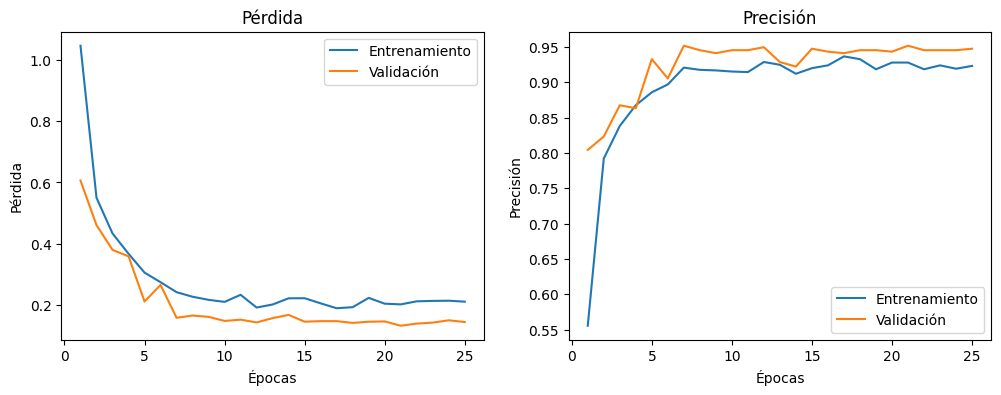

In [306]:
# Función para plotear el histórico de pérdidas y precisión
def plot_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    train_acc = [acc.item() for acc in train_acc]  
    val_acc = [acc.item() for acc in val_acc]  
    plt.plot(epochs, train_acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.show()

# Plotear el histórico
plot_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [307]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())

    return predictions, actuals


predictions, actuals = evaluate_model(model_py, dataloaders['val'])

df = pd.DataFrame({
    'Etiquetas Actuales': actuals,
    'Etiquetas Predichas': predictions
})

# Reemplazar etiquetas numéricas por descriptivas
label_map = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3:'pituitary'}
df['Etiquetas Actuales'] = df['Etiquetas Actuales'].replace(label_map)
df['Etiquetas Predichas'] = df['Etiquetas Predichas'].replace(label_map)

df

,Etiquetas Actuales,Etiquetas Predichas
0,notumor,notumor
1,glioma,glioma
2,pituitary,pituitary
3,glioma,glioma
4,pituitary,pituitary
...,...,...
470,glioma,glioma
471,notumor,notumor
472,glioma,glioma
473,meningioma,meningioma


In [308]:
# Identificar las etiquetas mal asignadas o predichas
misclassified = df[df['Etiquetas Actuales'] != df['Etiquetas Predichas']]

misclassified

,Etiquetas Actuales,Etiquetas Predichas
18,notumor,meningioma
53,meningioma,pituitary
56,notumor,glioma
67,meningioma,glioma
82,meningioma,notumor
111,meningioma,pituitary
160,meningioma,glioma
174,notumor,meningioma
200,pituitary,meningioma
215,pituitary,meningioma


In [309]:
# Calcular los porcentajes de missmatch por categoría
mismatch_counts = pd.crosstab(df['Etiquetas Actuales'], df['Etiquetas Predichas'], margins=True)
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

for category in categories:
    total_samples = mismatch_counts.loc[category, 'All']
    mismatch_samples = mismatch_counts.loc[category, category]
    mismatch_percentage = (mismatch_samples / total_samples) * 100
    print(f"Porcentaje de missmatch para la categoría '{category}': {mismatch_percentage:.2f}%")


Porcentaje de missmatch para la categoría 'glioma': 99.10%
Porcentaje de missmatch para la categoría 'meningioma': 89.47%
Porcentaje de missmatch para la categoría 'notumor': 97.90%
Porcentaje de missmatch para la categoría 'pituitary': 91.59%


In [310]:
# Filtrar las clasificaciones incorrectas
misclassified = df[df['Etiquetas Actuales'] != df['Etiquetas Predichas']]

# Contar las ocurrencias de cada combinación de clase real y clase predicha
misclass_counts = misclassified.groupby(['Etiquetas Actuales', 'Etiquetas Predichas']).size().reset_index(name='Count')

misclass_counts


,Etiquetas Actuales,Etiquetas Predichas,Count
0,glioma,meningioma,1
1,meningioma,glioma,6
2,meningioma,notumor,2
3,meningioma,pituitary,4
4,notumor,glioma,1
5,notumor,meningioma,2
6,pituitary,glioma,2
7,pituitary,meningioma,7


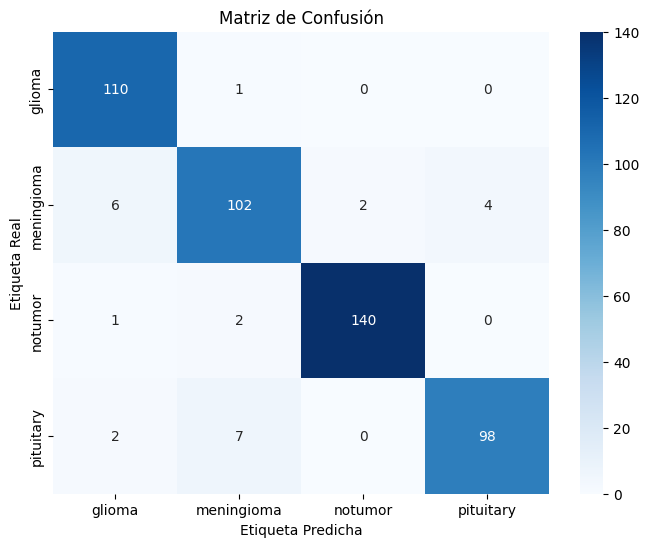

In [311]:
actuals_labels = [label_map[label] for label in actuals]
predicted_labels = [label_map[label] for label in predictions]

# Matriz de confusión
cm = confusion_matrix(actuals_labels, predicted_labels, labels=["glioma", "meningioma", 'notumor', 'pituitary'])

# Visualización de la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

In [312]:
# Reporte de clasificación
report = classification_report(actuals_labels, predicted_labels, target_names=label_map.values())
print("Reporte de Clasificación:\n", report)

Reporte de Clasificación:
               precision    recall  f1-score   support

      glioma       0.92      0.99      0.96       111
  meningioma       0.91      0.89      0.90       114
     notumor       0.99      0.98      0.98       143
   pituitary       0.96      0.92      0.94       107

    accuracy                           0.95       475
   macro avg       0.95      0.95      0.94       475
weighted avg       0.95      0.95      0.95       475



In [313]:
test_dataloader = dataloaders['val']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


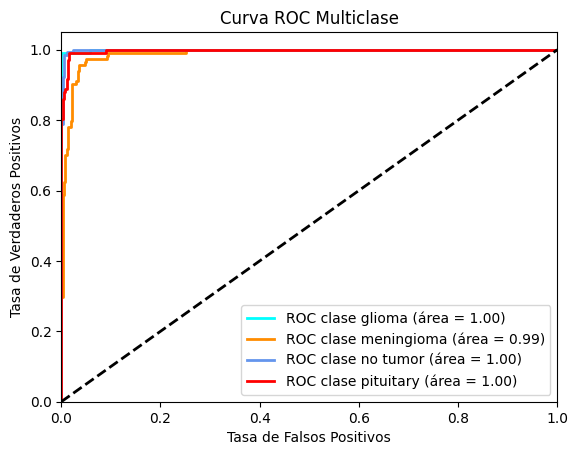

In [314]:
def plot_multiclass_roc(model, dataloader, class_names, device):
    model.eval()  # Poner el modelo en modo de evaluación
    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1) 

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())

    # Convertir las listas a arrays de numpy
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Binarizar las etiquetas
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Calcular ROC curve y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotear todas las curvas ROC
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC clase {0} (área = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC Multiclase')
    plt.legend(loc="lower right")
    plt.show()

# Plotear la curva ROC multiclase
plot_multiclass_roc(model_py, test_dataloader, class_names, device)

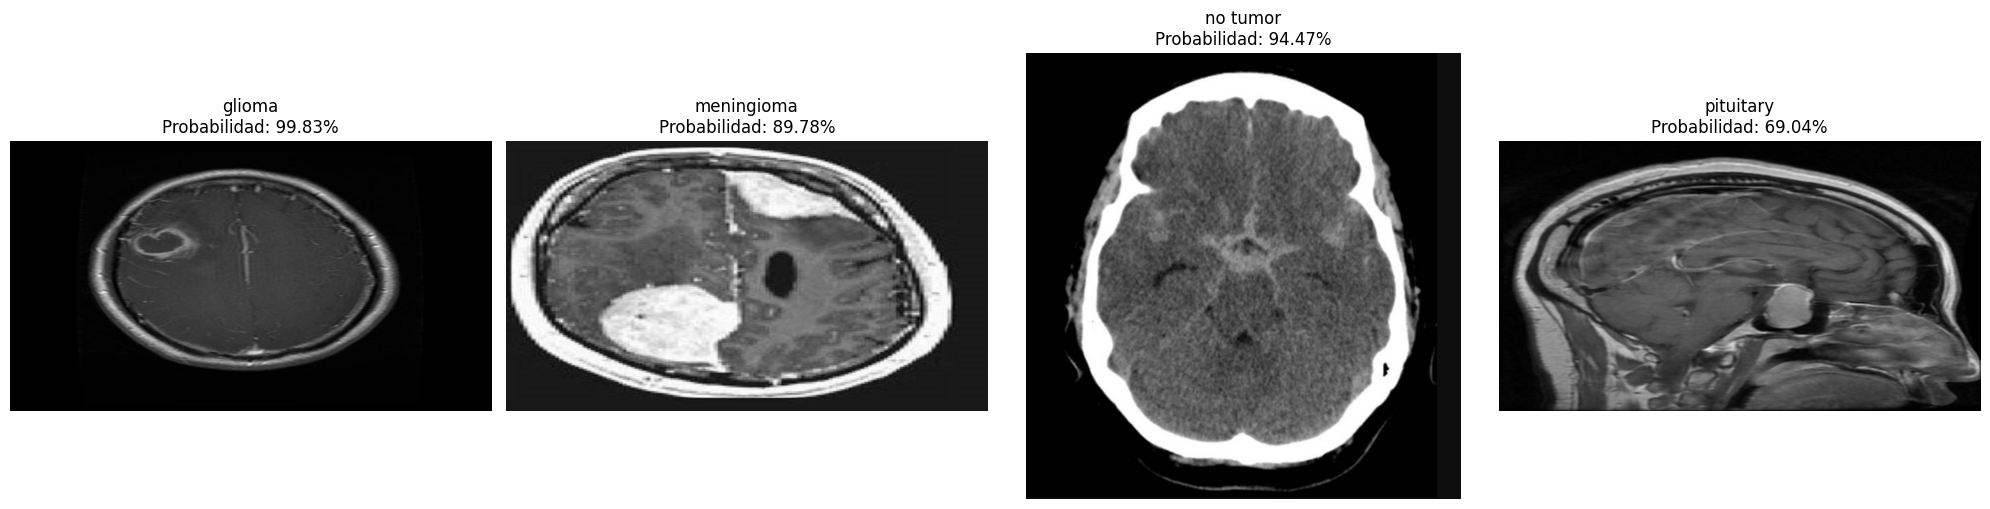

In [322]:
# Transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def predict_image(image_path, model, class_names, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0) 

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) * 100
        predicted_label = class_names[preds[0]]
        probability = probabilities[0, preds[0]].item()

    return predicted_label, probability

# Lista de rutas de imágenes
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA CANCER O NO 2.png',
    '/content/PRUEBA PI.png'
]

# Clases de las predicciones
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

# Crear subplots para mostrar las imágenes y sus predicciones
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, image_path in zip(axes, image_paths):
    label, prob = predict_image(image_path, model_py, class_names, transform)
    ax.imshow(Image.open(image_path))
    ax.set_title(f'{label}\nProbabilidad: {prob:.2f}%')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [334]:
model_py.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [335]:
# Transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [337]:
# Función para obtener el mapa de Grad-CAM
def get_grad_cam(image_tensor, model, target_layer):
    def save_gradient(grad):
        global gradients
        gradients = grad
        
    target_activations = None
    def forward_hook(module, input, output):
        nonlocal target_activations
        target_activations = output
        output.register_hook(save_gradient)

    handle = target_layer.register_forward_hook(forward_hook)


    output = model_py(image_tensor)
    class_idx = output.argmax().item()
    score = output[:, class_idx]

    model_py.zero_grad()
    score.backward(retain_graph=True)

  
    gradients_np = gradients.cpu().data.numpy()[0]
    target_activations_np = target_activations.cpu().data.numpy()[0]


    weights = np.mean(gradients_np, axis=(1, 2))
    grad_cam = np.zeros(target_activations_np.shape[1:], dtype=np.float32)


    for i, w in enumerate(weights):
        grad_cam += w * target_activations_np[i, :, :]

    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = cv2.resize(grad_cam, (image_tensor.shape[2], image_tensor.shape[3]))
    grad_cam = grad_cam - np.min(grad_cam)
    grad_cam = grad_cam / np.max(grad_cam)

    handle.remove()
    return grad_cam


def apply_grad_cam(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    target_layer = model_py.layer4  

    grad_cam_map = get_grad_cam(image_tensor, model_py, target_layer)

   
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  

    image = np.array(image.resize((256, 256))) / 255.0
    overlayed_image = heatmap + image
    overlayed_image = overlayed_image / np.max(overlayed_image)

    return overlayed_image

In [342]:
image_paths = [
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA CANCER O NO 2.png',
    '/content/PRUEBA PI.png'
]

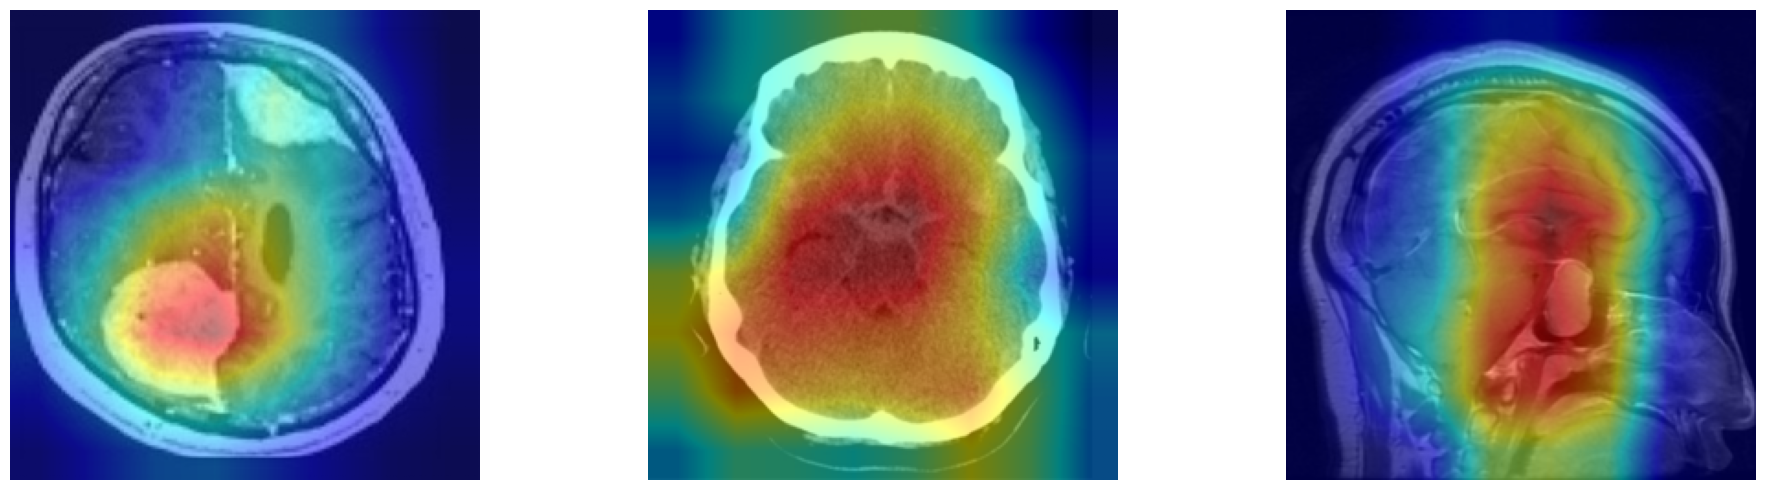

In [344]:
# Crear subplots para mostrar las imágenes y sus mapas de activación
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, image_path in zip(axes, image_paths):
    overlayed_image = apply_grad_cam(image_path, model_py, transform, device)
    ax.imshow(overlayed_image)
    ax.axis('off')

plt.tight_layout()
plt.show()